In [ ]:
from flyanalysis.braidz import read_braidz
import numpy as np
import pandas as pd
from tqdm import tqdm 
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
import seaborn as sns
import random
from scipy import stats


In [ ]:
files = ["20240603_105330.braidz", "20240607_105437.braidz","20240612_152825.braidz","20240702_140401.braidz","20240712_153309.braidz","20240715_171206.braidz"]

data = {}
for file in tqdm(files):
    data[file] = {}
    df, csvs = read_braidz("/home/buchsbaum/mnt/md0/Experiments/" + file)
    data[file]["df"] = df
    data[file]["csvs"] = csvs

In [60]:
file = []
trajectory_num = []
obj_ids = []
in_avoidence_zone = []

for key, value in data.items():
    
    # load data
    df = value["df"]
    stim = value["csvs"]["stim"]
    i = 0

    for obj_id, grp in df.groupby("obj_id"):
        if len(grp) < 300:
            continue
        
        x_median = np.median(grp.x.values)
        y_median = np.median(grp.y.values)
        z_median = np.median(grp.z.values)
        
        if (-0.2<=x_median<=0.2) and (-0.2<=y_median<=0.2) and (0.1<=z_median<=0.25):
            radius = np.sqrt(grp.x.values**2 + grp.y.values**2)
            in_avoidence_zone.append(np.sum((radius <= 0.025) & (grp.z.values>0.1) & (grp.z.values<0.25))/len(grp))
            trajectory_num.append(i)
            file.append(key)
            obj_ids.append(obj_id)
            i+=1

In [67]:
avoidence_df = pd.DataFrame({"file": file, "trajectory_num": trajectory_num, "obj_id": obj_ids, "in_avoidence_zone": in_avoidence_zone})

def bin_stim_number(group, n_bins=10):
    group['avoidence_binned'] = pd.qcut(group['trajectory_num'], q=n_bins, labels=False)
    return group

# Apply binning to each file
avoidence_df = avoidence_df.groupby('file').apply(bin_stim_number).reset_index(drop=True)


/tmp/ipykernel_176111/2836271598.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avoidence_df = avoidence_df.groupby('file').apply(bin_stim_number).reset_index(drop=True)


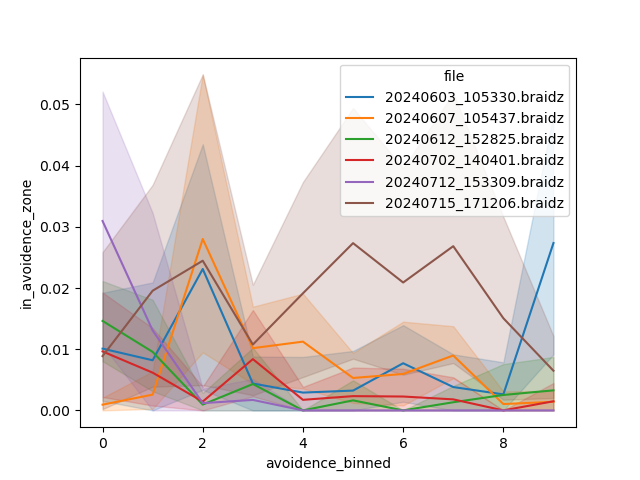

In [70]:
fig, ax = plt.subplots()
sns.lineplot(data=avoidence_df, x='avoidence_binned', y='in_avoidence_zone', hue='file', ax=ax)
plt.show()


In [ ]:
results = {"file": [],
           "stim_number": [],
           "obj_id": [],
           "stim_peak_value": [],
           "stim_peak_position": [],
           "avoidence_zone": []}

for key, value in data.items():
    
    # load data
    df = value["df"]
    stim = value["csvs"]["stim"]
    i = 0
    # loop over stim rows
    for index, row in stim.iterrows():
        obj_id = int(row["obj_id"])
        frame = int(row["frame"])

        # extract data
        grp = df[df["obj_id"] == obj_id]

        # get frame index
        try:
            stim_idx = np.where(grp["frame"] == frame)[0][0]
        except IndexError:
            continue

        # get start and end idx
        start_idx = stim_idx - 50
        end_idx = stim_idx + 100

        # check limits
        if start_idx < 0 or end_idx > len(grp):
            continue

        # calculate angular velocity
        theta = np.arctan2(grp.yvel.values, grp.xvel.values)
        theta_u = np.unwrap(theta)
        angular_velocity_all = np.gradient(theta_u) / (1 * 0.01)
        angular_velocity_stim = angular_velocity_all[start_idx:end_idx]
        angular_velocity_stim_abs = np.abs(angular_velocity_stim)

        # find peaks
        peaks, _ = find_peaks(angular_velocity_stim_abs, height=np.deg2rad(1000))

        # get value of peak within stim duration (50-80)
        stim_peak_position = [peak for peak in peaks if 50 < peak < 80]
        if len(stim_peak_position)>0:
            stim_peak_position = stim_peak_position[0]-50
            stim_peak_value = angular_velocity_stim_abs[stim_peak_position]
        else:
            stim_peak_value = np.nan
            stim_peak_position = np.nan

        # get avoidence zone
        radius = np.sqrt(grp.x.values**2 + grp.y.values**2)
        in_avoidence_zone = np.sum((radius <= 0.025) & (grp.z.values>0.1) & (grp.z.values<0.25))/len(grp)

        # add to results
        results["file"].append(key)
        results["stim_number"].append(i)
        results["obj_id"].append(obj_id)
        results["stim_peak_value"].append(stim_peak_value)
        results["stim_peak_position"].append(stim_peak_position)
        results["avoidence_zone"].append(in_avoidence_zone)
        i += 1

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
def bin_stim_number(group, n_bins=10):
    group['stim_bin'] = pd.qcut(group['stim_number'], q=n_bins, labels=False)
    return group

# Apply binning to each file
results_df = results_df.groupby('file').apply(bin_stim_number).reset_index(drop=True)

# Calculate the probability of NaN for each stim_bin and file
nan_prob = results_df.groupby(['file', 'stim_bin'])['stim_peak_value'].apply(lambda x: x.isna().mean()).reset_index()
nan_prob.columns = ['file', 'stim_bin', 'nan_probability']

# Create the plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=nan_prob, x='stim_bin', y='nan_probability', hue='file', marker='o')

plt.title('Probability of stim_peak_value being NaN over Binned Stimulus Number (Per File)')
plt.xlabel('Stimulus Bin')
plt.ylabel('Probability of NaN')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for probability

# Add a horizontal line at y=0.5 for reference
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)

plt.legend(title='File', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics for each file
for file in nan_prob['file'].unique():
    file_data = nan_prob[nan_prob['file'] == file]
    print(f"\nSummary for {file}:")
    print(file_data['nan_probability'].describe())
    
    # Calculate correlation for each file
    correlation, p_value = stats.pearsonr(file_data['stim_bin'], file_data['nan_probability'])
    print(f"Correlation between stim_bin and NaN probability: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

# Optional: Calculate overall trend
overall_correlation, overall_p_value = stats.pearsonr(nan_prob['stim_bin'], nan_prob['nan_probability'])
print(f"\nOverall correlation between stim_bin and NaN probability: {overall_correlation:.4f}")
print(f"Overall p-value: {overall_p_value:.4f}")

# Optional: Heatmap visualization
plt.figure(figsize=(15, 10))
heatmap_data = nan_prob.pivot(index='file', columns='stim_bin', values='nan_probability')
sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', vmin=0, vmax=1)
plt.title('Heatmap of NaN Probabilities Across Files and Stimulus Bins')
plt.xlabel('Stimulus Bin')
plt.ylabel('File')
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot stim_peak_value
sns.scatterplot(data=results_df, x='stim_number', y='stim_peak_value', hue='file', ax=ax1)
ax1.set_title('Distribution of Stimulus Peak Values by File')
ax1.set_xlabel('Binned Stimulus')  # Remove x-label as it's the same as in the second plot
ax1.set_ylabel('Stimulus Peak Value')
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Plot stim_peak_position
sns.scatterplot(data=results_df, x='stim_number', y='stim_peak_position', hue='file', ax=ax2)
ax2.set_title('Distribution of Stimulus Peak Positions by File')
ax2.set_xlabel('Binned Stimulus')
ax2.set_ylabel('Stimulus Peak Position')
ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
